<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Testing-pipeline" data-toc-modified-id="Testing-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Testing pipeline</a></span></li><li><span><a href="#Comparison-Sig-Kernel-and-RBF-Kernel" data-toc-modified-id="Comparison-Sig-Kernel-and-RBF-Kernel-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison Sig-Kernel and RBF-Kernel</a></span></li></ul></div>

In [5]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     
PROJ = 'My Drive/Distribution_Regression_Proj'       

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)

GIT_PATH = "https://d1f5fb17f9201eeb70248ecea10d65a859c2fffe@github.com/maudl3116/Distribution_Regression_Streams.git"

!git clone "{GIT_PATH}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'Distribution_Regression_Streams' already exists and is not an empty directory.


In [0]:
!pip install iisignature

In [0]:
%cd Distribution_Regression_Streams
!git pull

In [0]:
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import numpy as np
import data_generators.ellipsis
from data_generators import ellipsis
import utils
from utils import *
import GP_models as GP_models
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features
from signature_features import *
from experiment_script import exp1

In [0]:
import experiment_script
a,b = experiment_script.main(-3,-2)

In [201]:
print(a)

-3


**Generate data**

In [0]:
reload(ellipsis)

N_bags = 100
N_items = 15
tspan = np.linspace(0.0, 2*np.pi, 501)
spec_param = {'a':[1.,3.], 'b':[1.,3.]} #,'stdv_noise':[None]}

example = ellipsis.Ellipsis()
example.generate_data(N_bags=N_bags,N_items=N_items, t_span = tspan,spec_param=spec_param, stdv_pos=1., stdv_noise=0.3)
example.e_ang()


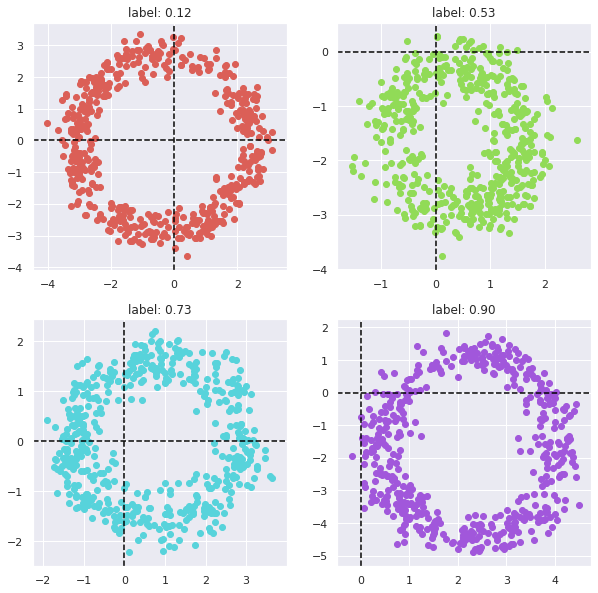

In [187]:
example.subsample_paths(N=100)
example.plot_subsampled_paths(N=2)

In [0]:
reload(utils)
noisy_labels = example.labels #+0.05*np.random.randn(len(example.labels),1)
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(noisy_labels,example.paths_sub,standardized=True,method='standard')

**Regression GP-RBF**

transf. var tensor([1.3133], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
transf. noise tensor([0.6932], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
transf. lengtshcale tensor([5.0067], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


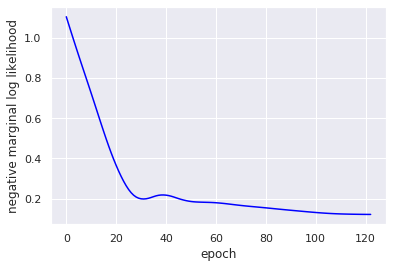

transf. var tensor([0.1180], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
transf. noise tensor([0.0197], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
transf. lengtshcale tensor([2.8002], device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


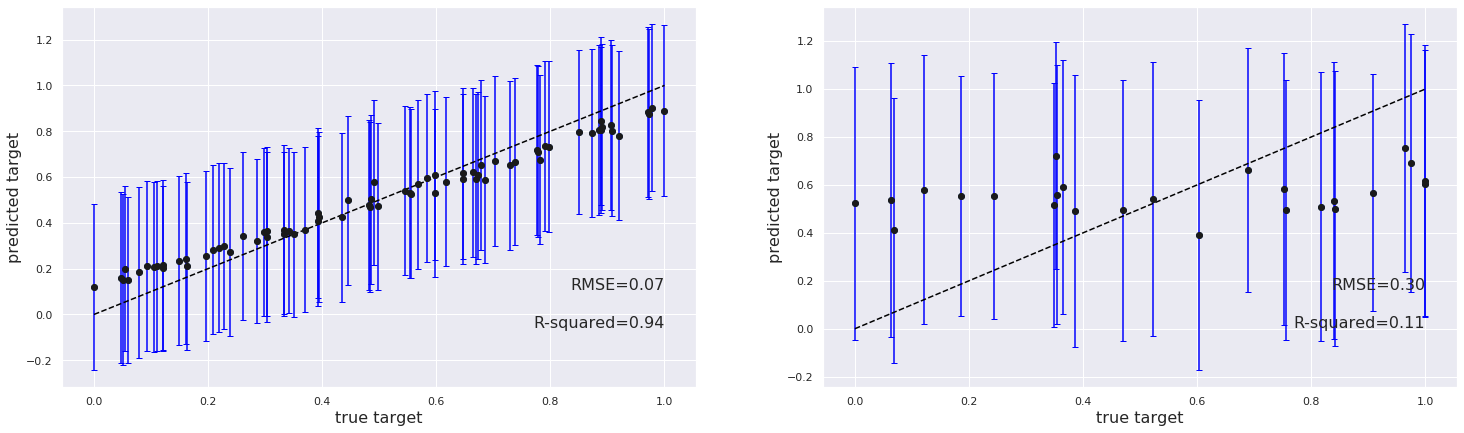

0.10859855342372293


In [192]:
reload(GP_naive)
reload(experiments)
res = []


# stack dimensions
dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
input_ = np.concatenate([dim_1,dim_2],axis=2)


train_naive, test_naive = experiments.naive_experiment(input_, y_scaled ,train_indices,test_indices,param_init=[5,1,0],plot=True,device=torch.device('cuda'))
res.append(test_naive)

print(np.mean(res))

**Regression GP-Sig**

maxi 2000.0


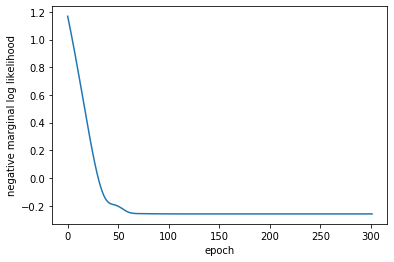

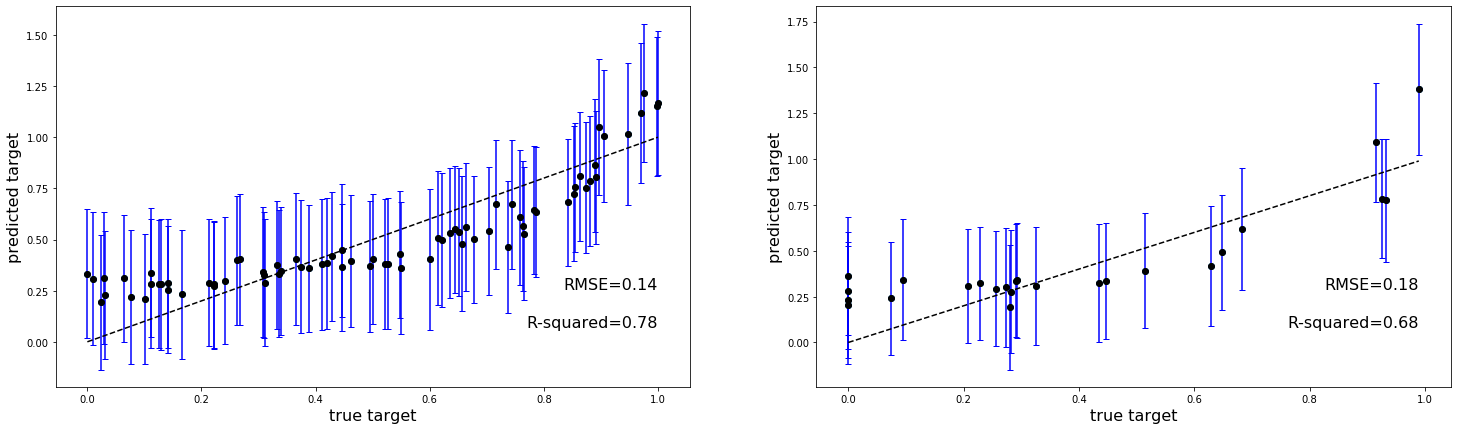

0.6756810691727434


In [71]:
# # specs for expected sig 
reload(signature_features)
reload(experiments)
reload(GP_sig)
sig_level1 = 6
M = 1000

results = []



# pathwise expected sig  
expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
K_precomputed = experiments.precompute_K(expected_pathwise_sig)
train, test = experiments.experiment_precomputed(K_precomputed, y_scaled,train_indices,test_indices, RBF=False,plot=True,device=torch.device('cuda'))
results.append(test)

print(np.mean(results))
      

**Loss landscape**

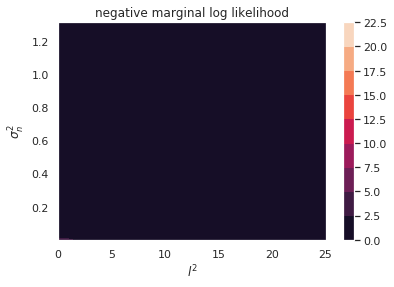

In [176]:
reload(GP_naive)
reload(experiments)
res = []


# stack dimensions
dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
input_ = np.concatenate([dim_1,dim_2],axis=2)


experiments.loss_naive(input_, y_scaled ,train_indices,test_indices)


In [0]:
# reload(signature_features)
# reload(experiments)
# reload(GP_sig)
# sig_level1 = 6
# M = 1000

# results = []



# # pathwise expected sig  
# expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
# K_precomputed = experiments.precompute_K(expected_pathwise_sig)
# experiments.loss_sig(K_precomputed, y_scaled, train_indices,test_indices)


# Comparison Sig-Kernel and RBF-Kernel

- evolution of performances with number of items
- evolution of performances with length time series
- evolution of performances with variance of centre ellipse
- evolution of performances with noise variance

In [193]:
#%cd Distribution_Regression_Streams
!git add .
!git commit -m 'test commit colab'
!git config --global user.email "maud.lemercier@spc.ox.ac.uk"
!git config --global user.name "maudl3116"
!git push origin "master"


[master e76a8e4] test commit colab
 6 files changed, 17 insertions(+), 14 deletions(-)
 rewrite GP_models/__pycache__/GP_classic.cpython-36.pyc (70%)
Counting objects: 13, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 5.70 KiB | 5.70 MiB/s, done.
Total 13 (delta 10), reused 0 (delta 0)
remote: Resolving deltas: 100% (10/10), completed with 10 local objects.
To https://github.com/maudl3116/Distribution_Regression_Streams.git
   dab829a..e76a8e4  master -> master


In [194]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/maudl3116/Distribution_Regression_Streams
   e76a8e4..994e0a4  master     -> origin/master
Updating e76a8e4..994e0a4
Fast-forward
 .DS_Store            | Bin 8196 -> 10244 bytes
 experiment_script.py |   7 +++++++
 2 files changed, 7 insertions(+)
 create mode 100644 experiment_script.py
